In [0]:
# Install PyDrive in the notebook since I'm running in Google Colab

!pip install -U -q PyDrive

In [2]:
from io import StringIO
from datetime import datetime

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import (Dense, Input, Conv1D, MaxPooling1D, Embedding,
                          GlobalMaxPooling1D, Flatten, Dropout)
from keras.models import Sequential, Model
from keras.initializers import Constant
from keras.layers.merge import concatenate

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

Using TensorFlow backend.


In [0]:
# Authenticate
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
# Model hyperparameters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = 100
FILTER_SIZES = [3,4,5]
BATCH_SIZE = 64
NUM_EPOCHS = 5

In [0]:

# List the files under my 'Colab Notebooks' directory in Google Drive
colab_files = drive.ListFile({'q': "'1p-TUsW0N_OJPJvlNSFiC4nrvz-jQMb1C' in parents and trashed=false"}).GetList()

def find_file(name, file_list):
  return [f for f in file_list if f['title'] == name][0]

# Find the GloVE embeddings and Glassdoor data files.
glove_txt = find_file('glove.6B.300d.txt', colab_files)
english_csv = find_file('Glassdoor_English_2018-07-13.csv', colab_files)

In [6]:
# Read the Glassdoor data into a CSV
df = pd.read_csv(StringIO(english_csv.GetContentString()), sep='\t')
df.head()

,Company,Date,Pros,Cons,Helpful,Page,Url,ScrapeDate,Language
0,3M,2014-02-16,"competitive salary, international opportunitie...","little room for lateral growth, not run as a m...",0.0,100,https://www.glassdoor.com/Reviews/3M-Reviews-E...,2018-07-13,en
1,3M,2014-03-05,Not too many benefits are about it,Isolation - People are under a lot of pressure...,1.0,100,https://www.glassdoor.com/Reviews/3M-Reviews-E...,2018-07-13,en
2,3M,2014-01-28,"Benefits, fitness center, high tech environmen...","Lack of flexibility, e.g. no opportunity to wo...",0.0,100,https://www.glassdoor.com/Reviews/3M-Reviews-E...,2018-07-13,en
3,3M,2014-01-29,"Everyone treats you as their equal, and encour...",There are no cons in my opinion.,0.0,100,https://www.glassdoor.com/Reviews/3M-Reviews-E...,2018-07-13,en
4,3M,2014-01-23,"Outstanding benefits, great advancement opport...","Some employees can be aggressive, HR policies ...",0.0,100,https://www.glassdoor.com/Reviews/3M-Reviews-E...,2018-07-13,en


In [0]:
# Preprocessing 
# 1. Binarize the Helpful columns to 0 and 1; 1 if > 0, 0 otherwise.
# 2. Create a new Review column by concatenating the Pros and Cons columns
# 3. Filter to only where Review is not null, and filter to only the data & label columns
df['IsHelpful'] = df['Helpful'].gt(0).astype(int)
df['Review'] = (df['Pros'] + '. ' + df['Cons']).str.lower()
df = df.loc[~df['Review'].isnull(), ['Review', 'IsHelpful']]

In [0]:

# Tokenize & pad the text. Find the max sequence length.
texts = df['Review'].tolist()
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

MAX_SEQUENCE_LENGTH = max(len(s) for s in sequences)

X = pad_sequences(sequences, padding='post')
y = df['IsHelpful'].values

In [0]:
# Create a dictionary of each word -> vector
embeddings_index = {}

for line in glove_lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [45]:
# Create the initial embedding matrix as a NumPy array.
# ToDo: finish this; for now I'll just do embeddings from scratch
chained = []

for seq in sequences:
  chained += seq

distinct_ids = list(set(chained))

word_to_id = tokenizer.word_index
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for i in range(VOCAB_SIZE):
    word = id_to_word[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

KeyError: ignored

In [0]:
import itertools

In [0]:
chained = []

for seq in sequences:
  chained += seq

distinct_vocab = set(chained)

In [0]:
seq = sequences[0]

In [34]:
df['Review'].iloc[0]

'competitive salary, international opportunities, innovative product offering, top-notch r&d department, adequate benefits. little room for lateral growth, not run as a meritocracy, incredibly political for career advancement, incompetent management, diversity is lacking, difficult to retain young talent'

In [41]:


text = ' '.join(id_to_word[i] for i in seq)
print(text)

competitive salary international opportunities innovative product offering top notch r d department adequate benefits little room for lateral growth not run as a meritocracy incredibly political for career advancement incompetent management diversity is lacking difficult to retain young talent


In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [22]:
# Model hyperparameters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = 100
FILTER_SIZES = [5, 15, 30]
BATCH_SIZE = 64
NUM_EPOCHS = 5
DROPOUT_RATES = [0, 0.1, 0.2, 0.3, 0.4, 0.5]


for drop in DROPOUT_RATES:
    print('========================================================')
    print('Dropout rate: {}'.format(drop))
    print('========================================================')

    inputs = []
    channels = []

    for filter_size in FILTER_SIZES:
        input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
        inputs.append(input_)

        channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True)(input_)
        channel = Conv1D(filters=100, kernel_size=filter_size, padding='valid', 
                   activation='relu')(channel)
        channel = MaxPooling1D(2)(channel)
        channel = Flatten()(channel)
        channels.append(channel)

    merged = concatenate(channels)
    merged = Dropout(drop)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    print(model.summary())

    model.fit([X_train, X_train, X_train], y_train, epochs=NUM_EPOCHS, 
              batch_size=BATCH_SIZE, validation_split=0.2)

    y_test_pred = model.predict([X_test, X_test, X_test])
    acc = accuracy_score(y_test, np.rint(y_test_pred))

    print('Accuracy score: {}'.format(acc))

Dropout rate: 0
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_14 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_15 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_16 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_14 (Embedding)        (None, 175, 300)     3000000     input_14[0][0]                   
_____________________________________________________________________________________________

186688/186708 [============================>.] - ETA: 0s - loss: 0.5251 - acc: 0.7504

186708/186708 [==============================] - 267s 1ms/step - loss: 0.5251 - acc: 0.7504 - val_loss: 0.5187 - val_acc: 0.7548
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.4496 - acc: 0.8041

186688/186708 [============================>.] - ETA: 0s - loss: 0.4594 - acc: 0.7956

186708/186708 [==============================] - 263s 1ms/step - loss: 0.4594 - acc: 0.7956 - val_loss: 0.5629 - val_acc: 0.7432
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.2625 - acc: 0.9007

186688/186708 [============================>.] - ETA: 0s - loss: 0.2767 - acc: 0.8904

186708/186708 [==============================] - 266s 1ms/step - loss: 0.2767 - acc: 0.8903 - val_loss: 0.7647 - val_acc: 0.7262
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:26 - loss: 0.1289 - acc: 0.9562

186688/186708 [============================>.] - ETA: 0s - loss: 0.1442 - acc: 0.9475

186708/186708 [==============================] - 263s 1ms/step - loss: 0.1442 - acc: 0.9475 - val_loss: 1.1356 - val_acc: 0.7171
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.0652 - acc: 0.9791

186688/186708 [============================>.] - ETA: 0s - loss: 0.0882 - acc: 0.9694

186708/186708 [==============================] - 265s 1ms/step - loss: 0.0882 - acc: 0.9694 - val_loss: 1.4627 - val_acc: 0.7149
Accuracy score: 0.7071957427117076
Dropout rate: 0.1
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_18 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_19 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_17 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5248 - acc: 0.7497

186708/186708 [==============================] - 268s 1ms/step - loss: 0.5248 - acc: 0.7497 - val_loss: 0.5155 - val_acc: 0.7569
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:30 - loss: 0.4557 - acc: 0.7977

186688/186708 [============================>.] - ETA: 0s - loss: 0.4674 - acc: 0.7908

186708/186708 [==============================] - 265s 1ms/step - loss: 0.4674 - acc: 0.7908 - val_loss: 0.5497 - val_acc: 0.7442
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.2900 - acc: 0.8886

186688/186708 [============================>.] - ETA: 0s - loss: 0.3106 - acc: 0.8744

186708/186708 [==============================] - 267s 1ms/step - loss: 0.3106 - acc: 0.8744 - val_loss: 0.7125 - val_acc: 0.7337
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.1604 - acc: 0.9436

186688/186708 [============================>.] - ETA: 0s - loss: 0.1827 - acc: 0.9308

186708/186708 [==============================] - 266s 1ms/step - loss: 0.1827 - acc: 0.9308 - val_loss: 0.9904 - val_acc: 0.7128
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.0962 - acc: 0.9656

186688/186708 [============================>.] - ETA: 0s - loss: 0.1222 - acc: 0.9548

186708/186708 [==============================] - 265s 1ms/step - loss: 0.1222 - acc: 0.9548 - val_loss: 1.2872 - val_acc: 0.6986
Accuracy score: 0.6985963288600956
Dropout rate: 0.2
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_20 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_21 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_22 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_20 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5268 - acc: 0.7488

186708/186708 [==============================] - 268s 1ms/step - loss: 0.5268 - acc: 0.7488 - val_loss: 0.5199 - val_acc: 0.7567
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:32 - loss: 0.4566 - acc: 0.7973

186688/186708 [============================>.] - ETA: 0s - loss: 0.4712 - acc: 0.7885

186708/186708 [==============================] - 265s 1ms/step - loss: 0.4713 - acc: 0.7885 - val_loss: 0.5457 - val_acc: 0.7444
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:31 - loss: 0.3112 - acc: 0.8760

186688/186708 [============================>.] - ETA: 0s - loss: 0.3307 - acc: 0.8644

186708/186708 [==============================] - 270s 1ms/step - loss: 0.3307 - acc: 0.8644 - val_loss: 0.6844 - val_acc: 0.7232
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.1880 - acc: 0.9290

186688/186708 [============================>.] - ETA: 0s - loss: 0.2123 - acc: 0.9179

186708/186708 [==============================] - 264s 1ms/step - loss: 0.2123 - acc: 0.9178 - val_loss: 0.8910 - val_acc: 0.7110
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.1252 - acc: 0.9553

186688/186708 [============================>.] - ETA: 0s - loss: 0.1538 - acc: 0.9423

186708/186708 [==============================] - 265s 1ms/step - loss: 0.1538 - acc: 0.9423 - val_loss: 1.1018 - val_acc: 0.7127
Accuracy score: 0.7105892333796082
Dropout rate: 0.3
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_23 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_24 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_25 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_23 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5276 - acc: 0.7486

186708/186708 [==============================] - 272s 1ms/step - loss: 0.5277 - acc: 0.7486 - val_loss: 0.5224 - val_acc: 0.7550
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:33 - loss: 0.4575 - acc: 0.7981

186688/186708 [============================>.] - ETA: 0s - loss: 0.4761 - acc: 0.7858

186708/186708 [==============================] - 269s 1ms/step - loss: 0.4761 - acc: 0.7858 - val_loss: 0.5476 - val_acc: 0.7486
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.3197 - acc: 0.8732

186688/186708 [============================>.] - ETA: 0s - loss: 0.3499 - acc: 0.8547

186708/186708 [==============================] - 264s 1ms/step - loss: 0.3499 - acc: 0.8547 - val_loss: 0.6505 - val_acc: 0.7320
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.2113 - acc: 0.9194

186688/186708 [============================>.] - ETA: 0s - loss: 0.2409 - acc: 0.9056

186708/186708 [==============================] - 269s 1ms/step - loss: 0.2409 - acc: 0.9056 - val_loss: 0.8299 - val_acc: 0.7221
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:31 - loss: 0.1507 - acc: 0.9438

186688/186708 [============================>.] - ETA: 0s - loss: 0.1818 - acc: 0.9311

186708/186708 [==============================] - 270s 1ms/step - loss: 0.1818 - acc: 0.9311 - val_loss: 1.0360 - val_acc: 0.7203
Accuracy score: 0.7135199753200678
Dropout rate: 0.4
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_26 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_27 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_28 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_26 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5281 - acc: 0.7475

186708/186708 [==============================] - 268s 1ms/step - loss: 0.5281 - acc: 0.7475 - val_loss: 0.5162 - val_acc: 0.7565
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.4587 - acc: 0.7975

186688/186708 [============================>.] - ETA: 0s - loss: 0.4823 - acc: 0.7824

186708/186708 [==============================] - 269s 1ms/step - loss: 0.4823 - acc: 0.7823 - val_loss: 0.5430 - val_acc: 0.7441
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:32 - loss: 0.3534 - acc: 0.8577

186688/186708 [============================>.] - ETA: 0s - loss: 0.3821 - acc: 0.8394

186708/186708 [==============================] - 265s 1ms/step - loss: 0.3822 - acc: 0.8394 - val_loss: 0.6165 - val_acc: 0.7328
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:30 - loss: 0.2588 - acc: 0.8989

186688/186708 [============================>.] - ETA: 0s - loss: 0.2867 - acc: 0.8856

186708/186708 [==============================] - 269s 1ms/step - loss: 0.2867 - acc: 0.8856 - val_loss: 0.7516 - val_acc: 0.7358
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.1947 - acc: 0.9259

186688/186708 [============================>.] - ETA: 0s - loss: 0.2305 - acc: 0.9103

186708/186708 [==============================] - 264s 1ms/step - loss: 0.2305 - acc: 0.9103 - val_loss: 0.8727 - val_acc: 0.7252
Accuracy score: 0.7158722813512263
Dropout rate: 0.5
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_29 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_30 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_31 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_29 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5300 - acc: 0.7476

186708/186708 [==============================] - 271s 1ms/step - loss: 0.5300 - acc: 0.7476 - val_loss: 0.5165 - val_acc: 0.7549
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:32 - loss: 0.4652 - acc: 0.7916

186688/186708 [============================>.] - ETA: 0s - loss: 0.4907 - acc: 0.7765

186708/186708 [==============================] - 266s 1ms/step - loss: 0.4907 - acc: 0.7765 - val_loss: 0.5350 - val_acc: 0.7462
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.3882 - acc: 0.8362

186688/186708 [============================>.] - ETA: 0s - loss: 0.4174 - acc: 0.8200

186708/186708 [==============================] - 264s 1ms/step - loss: 0.4174 - acc: 0.8200 - val_loss: 0.5885 - val_acc: 0.7418
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:32 - loss: 0.3040 - acc: 0.8791

186688/186708 [============================>.] - ETA: 0s - loss: 0.3394 - acc: 0.8609

186708/186708 [==============================] - 268s 1ms/step - loss: 0.3394 - acc: 0.8609 - val_loss: 0.6659 - val_acc: 0.7295
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.2456 - acc: 0.9034

186688/186708 [============================>.] - ETA: 0s - loss: 0.2837 - acc: 0.8864

186708/186708 [==============================] - 267s 1ms/step - loss: 0.2837 - acc: 0.8864 - val_loss: 0.8032 - val_acc: 0.7225
Accuracy score: 0.7177232762609903


In [23]:
# Model hyperparameters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = 100
FILTER_SIZES = [5, 15, 30]
BATCH_SIZE = 64
NUM_EPOCHS = 5
DROPOUT_RATES = [0.6, 0.7, 0.8, 0.9]


for drop in DROPOUT_RATES:
    print('========================================================')
    print('Dropout rate: {}'.format(drop))
    print('========================================================')

    inputs = []
    channels = []

    for filter_size in FILTER_SIZES:
        input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
        inputs.append(input_)

        channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True)(input_)
        channel = Conv1D(filters=100, kernel_size=filter_size, padding='valid', 
                   activation='relu')(channel)
        channel = MaxPooling1D(2)(channel)
        channel = Flatten()(channel)
        channels.append(channel)

    merged = concatenate(channels)
    merged = Dropout(drop)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    print(model.summary())

    model.fit([X_train, X_train, X_train], y_train, epochs=NUM_EPOCHS, 
              batch_size=BATCH_SIZE, validation_split=0.2)

    y_test_pred = model.predict([X_test, X_test, X_test])
    acc = accuracy_score(y_test, np.rint(y_test_pred))

    print('Accuracy score: {}'.format(acc))

Dropout rate: 0.6
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_32 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_33 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_34 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_32 (Embedding)        (None, 175, 300)     3000000     input_32[0][0]                   
___________________________________________________________________________________________

186688/186708 [============================>.] - ETA: 0s - loss: 0.5323 - acc: 0.7468

186708/186708 [==============================] - 272s 1ms/step - loss: 0.5323 - acc: 0.7468 - val_loss: 0.5183 - val_acc: 0.7563
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.4775 - acc: 0.7852

186688/186708 [============================>.] - ETA: 0s - loss: 0.5003 - acc: 0.7709

186708/186708 [==============================] - 264s 1ms/step - loss: 0.5003 - acc: 0.7709 - val_loss: 0.5264 - val_acc: 0.7503
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.4217 - acc: 0.8189

186688/186708 [============================>.] - ETA: 0s - loss: 0.4504 - acc: 0.8024

186708/186708 [==============================] - 264s 1ms/step - loss: 0.4504 - acc: 0.8024 - val_loss: 0.5511 - val_acc: 0.7463
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:31 - loss: 0.3527 - acc: 0.8560

186688/186708 [============================>.] - ETA: 0s - loss: 0.3903 - acc: 0.8355

186708/186708 [==============================] - 269s 1ms/step - loss: 0.3903 - acc: 0.8355 - val_loss: 0.6100 - val_acc: 0.7388
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:30 - loss: 0.3052 - acc: 0.8769

186688/186708 [============================>.] - ETA: 0s - loss: 0.3409 - acc: 0.8599

186708/186708 [==============================] - 264s 1ms/step - loss: 0.3409 - acc: 0.8599 - val_loss: 0.6712 - val_acc: 0.7342
Accuracy score: 0.7319913620237545
Dropout rate: 0.7
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_35 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_36 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_37 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_35 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5356 - acc: 0.7445

186708/186708 [==============================] - 272s 1ms/step - loss: 0.5356 - acc: 0.7445 - val_loss: 0.5201 - val_acc: 0.7566
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:33 - loss: 0.4850 - acc: 0.7804

186688/186708 [============================>.] - ETA: 0s - loss: 0.5086 - acc: 0.7660

186708/186708 [==============================] - 267s 1ms/step - loss: 0.5086 - acc: 0.7660 - val_loss: 0.5247 - val_acc: 0.7539
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.4604 - acc: 0.7968

186688/186708 [============================>.] - ETA: 0s - loss: 0.4811 - acc: 0.7839

186708/186708 [==============================] - 265s 1ms/step - loss: 0.4812 - acc: 0.7839 - val_loss: 0.5401 - val_acc: 0.7496
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:32 - loss: 0.4204 - acc: 0.8186

186688/186708 [============================>.] - ETA: 0s - loss: 0.4465 - acc: 0.8052

186708/186708 [==============================] - 268s 1ms/step - loss: 0.4465 - acc: 0.8052 - val_loss: 0.5676 - val_acc: 0.7446
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:28 - loss: 0.3869 - acc: 0.8372

186688/186708 [============================>.] - ETA: 0s - loss: 0.4115 - acc: 0.8254

186708/186708 [==============================] - 264s 1ms/step - loss: 0.4116 - acc: 0.8254 - val_loss: 0.5970 - val_acc: 0.7424
Accuracy score: 0.7427117075428042
Dropout rate: 0.8
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_38 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_39 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_40 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_38 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5387 - acc: 0.7433

186708/186708 [==============================] - 271s 1ms/step - loss: 0.5388 - acc: 0.7433 - val_loss: 0.5172 - val_acc: 0.7552
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:31 - loss: 0.5016 - acc: 0.7696

186688/186708 [============================>.] - ETA: 0s - loss: 0.5182 - acc: 0.7597

186708/186708 [==============================] - 268s 1ms/step - loss: 0.5182 - acc: 0.7597 - val_loss: 0.5269 - val_acc: 0.7540
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.4847 - acc: 0.7823

186688/186708 [============================>.] - ETA: 0s - loss: 0.5035 - acc: 0.7694

186708/186708 [==============================] - 263s 1ms/step - loss: 0.5035 - acc: 0.7694 - val_loss: 0.5373 - val_acc: 0.7505
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:30 - loss: 0.4693 - acc: 0.7889

165824/186708 [=========================>....] - ETA: 27s - loss: 0.4886 - acc: 0.7799

186708/186708 [==============================] - 269s 1ms/step - loss: 0.4905 - acc: 0.7789 - val_loss: 0.5437 - val_acc: 0.7501
Epoch 5/5
 20288/186708 [==>...........................] - ETA: 3:41 - loss: 0.4510 - acc: 0.8006

186688/186708 [============================>.] - ETA: 0s - loss: 0.4770 - acc: 0.7877

186708/186708 [==============================] - 264s 1ms/step - loss: 0.4770 - acc: 0.7877 - val_loss: 0.5562 - val_acc: 0.7497
Accuracy score: 0.7447555144223353
Dropout rate: 0.9
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_41 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_42 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_43 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_41 (Embedding)  

186688/186708 [============================>.] - ETA: 0s - loss: 0.5482 - acc: 0.7382

186708/186708 [==============================] - 271s 1ms/step - loss: 0.5482 - acc: 0.7382 - val_loss: 0.5226 - val_acc: 0.7543
Epoch 2/5
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.5247 - acc: 0.7562

186688/186708 [============================>.] - ETA: 0s - loss: 0.5346 - acc: 0.7502

186708/186708 [==============================] - 263s 1ms/step - loss: 0.5345 - acc: 0.7502 - val_loss: 0.5285 - val_acc: 0.7523
Epoch 3/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.5215 - acc: 0.7581

186688/186708 [============================>.] - ETA: 0s - loss: 0.5290 - acc: 0.7558

186708/186708 [==============================] - 267s 1ms/step - loss: 0.5290 - acc: 0.7558 - val_loss: 0.5395 - val_acc: 0.7511
Epoch 4/5
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.5239 - acc: 0.7609

186688/186708 [============================>.] - ETA: 0s - loss: 0.5272 - acc: 0.7585

186708/186708 [==============================] - 268s 1ms/step - loss: 0.5272 - acc: 0.7585 - val_loss: 0.5406 - val_acc: 0.7487
Epoch 5/5
 28224/186708 [===>..........................] - ETA: 3:27 - loss: 0.5167 - acc: 0.7636

186688/186708 [============================>.] - ETA: 0s - loss: 0.5235 - acc: 0.7606

186708/186708 [==============================] - 263s 1ms/step - loss: 0.5235 - acc: 0.7606 - val_loss: 0.5437 - val_acc: 0.7521
Accuracy score: 0.7453339503316366


In [29]:
# Experiment with different numbers of filters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = [100, 200, 400]
FILTER_SIZES = [5, 15, 30]
BATCH_SIZE = 64
NUM_EPOCHS = 3


for num_filters in NUM_FILTERS:
    print('========================================================')
    print('Number of filters: {}'.format(num_filters))
    print('========================================================')

    inputs = []
    channels = []

    for filter_size in FILTER_SIZES:
        input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
        inputs.append(input_)

        channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True)(input_)
        channel = Conv1D(filters=num_filters, kernel_size=filter_size, padding='valid', 
                   activation='relu')(channel)
        channel = MaxPooling1D(2)(channel)
        channel = Flatten()(channel)
        channels.append(channel)

    merged = concatenate(channels)
    merged = Dropout(0.9)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    print(model.summary())

    model.fit([X_train, X_train, X_train], y_train, epochs=NUM_EPOCHS, 
              batch_size=BATCH_SIZE, validation_split=0.2)

    y_test_pred = model.predict([X_test, X_test, X_test])
    acc = accuracy_score(y_test, np.rint(y_test_pred))

    print('Accuracy score: {}'.format(acc))

Number of filters: 100
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_45 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_46 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_47 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_45 (Embedding)        (None, 175, 300)     3000000     input_45[0][0]                   
______________________________________________________________________________________

186688/186708 [============================>.] - ETA: 0s - loss: 0.5495 - acc: 0.7376

186708/186708 [==============================] - 273s 1ms/step - loss: 0.5495 - acc: 0.7376 - val_loss: 0.5225 - val_acc: 0.7526
Epoch 2/3
 28224/186708 [===>..........................] - ETA: 3:29 - loss: 0.5240 - acc: 0.7577

186688/186708 [============================>.] - ETA: 0s - loss: 0.5344 - acc: 0.7501

186708/186708 [==============================] - 264s 1ms/step - loss: 0.5344 - acc: 0.7501 - val_loss: 0.5250 - val_acc: 0.7522
Epoch 3/3
 28224/186708 [===>..........................] - ETA: 3:31 - loss: 0.5168 - acc: 0.7588

186688/186708 [============================>.] - ETA: 0s - loss: 0.5300 - acc: 0.7543

186708/186708 [==============================] - 266s 1ms/step - loss: 0.5300 - acc: 0.7543 - val_loss: 0.5329 - val_acc: 0.7476
Accuracy score: 0.7445627024525683
Number of filters: 200
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_48 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_49 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_50 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_48 (Embeddi

186688/186708 [============================>.] - ETA: 0s - loss: 0.5539 - acc: 0.7362

186708/186708 [==============================] - 420s 2ms/step - loss: 0.5539 - acc: 0.7362 - val_loss: 0.5211 - val_acc: 0.7540
Epoch 2/3
 28224/186708 [===>..........................] - ETA: 5:22 - loss: 0.5179 - acc: 0.7623

186688/186708 [============================>.] - ETA: 0s - loss: 0.5376 - acc: 0.7489

186708/186708 [==============================] - 416s 2ms/step - loss: 0.5376 - acc: 0.7489 - val_loss: 0.5254 - val_acc: 0.7540
Epoch 3/3
 28224/186708 [===>..........................] - ETA: 5:20 - loss: 0.5170 - acc: 0.7610

186688/186708 [============================>.] - ETA: 0s - loss: 0.5302 - acc: 0.7546

186708/186708 [==============================] - 415s 2ms/step - loss: 0.5302 - acc: 0.7546 - val_loss: 0.5339 - val_acc: 0.7497
Accuracy score: 0.7448712016041956
Number of filters: 400
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_51 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_52 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_53 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_51 (Embeddi

186688/186708 [============================>.] - ETA: 0s - loss: 0.5585 - acc: 0.7339

186708/186708 [==============================] - 788s 4ms/step - loss: 0.5585 - acc: 0.7339 - val_loss: 0.5206 - val_acc: 0.7545
Epoch 2/3
 20352/186708 [==>...........................] - ETA: 10:38 - loss: 0.5256 - acc: 0.7549

186688/186708 [============================>.] - ETA: 0s - loss: 0.5397 - acc: 0.7482

186708/186708 [==============================] - 774s 4ms/step - loss: 0.5398 - acc: 0.7482 - val_loss: 0.5257 - val_acc: 0.7499
Epoch 3/3
 20352/186708 [==>...........................] - ETA: 10:41 - loss: 0.5203 - acc: 0.7589

186688/186708 [============================>.] - ETA: 0s - loss: 0.5345 - acc: 0.7538

186708/186708 [==============================] - 776s 4ms/step - loss: 0.5345 - acc: 0.7538 - val_loss: 0.5336 - val_acc: 0.7465
Accuracy score: 0.7428659571186179


In [30]:
# Experiment with different numbers of filters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = [10, 25, 50]
FILTER_SIZES = [5, 15, 30]
BATCH_SIZE = 64
NUM_EPOCHS = 3


for num_filters in NUM_FILTERS:
    print('========================================================')
    print('Number of filters: {}'.format(num_filters))
    print('========================================================')

    inputs = []
    channels = []

    for filter_size in FILTER_SIZES:
        input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
        inputs.append(input_)

        channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                      input_length=MAX_SEQUENCE_LENGTH,
                      trainable=True)(input_)
        channel = Conv1D(filters=num_filters, kernel_size=filter_size, padding='valid', 
                   activation='relu')(channel)
        channel = MaxPooling1D(2)(channel)
        channel = Flatten()(channel)
        channels.append(channel)

    merged = concatenate(channels)
    merged = Dropout(0.9)(merged)
    outputs = Dense(1, activation='sigmoid')(merged)

    model = Model(inputs=inputs, outputs=outputs)
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])


    print(model.summary())

    model.fit([X_train, X_train, X_train], y_train, epochs=NUM_EPOCHS, 
              batch_size=BATCH_SIZE, validation_split=0.2)

    y_test_pred = model.predict([X_test, X_test, X_test])
    acc = accuracy_score(y_test, np.rint(y_test_pred))

    print('Accuracy score: {}'.format(acc))

Number of filters: 10
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_54 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_55 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_56 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_54 (Embedding)        (None, 175, 300)     3000000     input_54[0][0]                   
_______________________________________________________________________________________

186624/186708 [============================>.] - ETA: 0s - loss: 0.5460 - acc: 0.7404

186708/186708 [==============================] - 141s 756us/step - loss: 0.5460 - acc: 0.7404 - val_loss: 0.5223 - val_acc: 0.7502
Epoch 2/3
 54336/186708 [=======>......................] - ETA: 1:30 - loss: 0.5259 - acc: 0.7571

186708/186708 [==============================] - 136s 729us/step - loss: 0.5316 - acc: 0.7517 - val_loss: 0.5237 - val_acc: 0.7519
Epoch 3/3
  5056/186708 [..............................] - ETA: 2:03 - loss: 0.5250 - acc: 0.7565

186688/186708 [============================>.] - ETA: 0s - loss: 0.5264 - acc: 0.7558

186708/186708 [==============================] - 141s 756us/step - loss: 0.5264 - acc: 0.7558 - val_loss: 0.5282 - val_acc: 0.7518
Accuracy score: 0.7482261298781429
Number of filters: 25
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_57 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_58 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_59 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_57 (Embedd

186624/186708 [============================>.] - ETA: 0s - loss: 0.5444 - acc: 0.7408

186708/186708 [==============================] - 151s 807us/step - loss: 0.5444 - acc: 0.7408 - val_loss: 0.5209 - val_acc: 0.7505
Epoch 2/3
 52608/186708 [=======>......................] - ETA: 1:36 - loss: 0.5233 - acc: 0.7571

186624/186708 [============================>.] - ETA: 0s - loss: 0.5298 - acc: 0.7526

186708/186708 [==============================] - 146s 782us/step - loss: 0.5298 - acc: 0.7526 - val_loss: 0.5208 - val_acc: 0.7539
Epoch 3/3
 48832/186708 [======>.......................] - ETA: 1:41 - loss: 0.5169 - acc: 0.7609

186688/186708 [============================>.] - ETA: 0s - loss: 0.5237 - acc: 0.7577

186708/186708 [==============================] - 147s 786us/step - loss: 0.5237 - acc: 0.7577 - val_loss: 0.5265 - val_acc: 0.7500
Accuracy score: 0.7450640135739627
Number of filters: 50
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_60 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_61 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
input_62 (InputLayer)           (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_60 (Embedd

 70080/186708 [==========>...................] - ETA: 2:09 - loss: 0.5522 - acc: 0.7344

140928/186708 [=====================>........] - ETA: 49s - loss: 0.5469 - acc: 0.7388

186708/186708 [==============================] - 217s 1ms/step - loss: 0.5459 - acc: 0.7393 - val_loss: 0.5195 - val_acc: 0.7542
Epoch 2/3
  7488/186708 [>.............................] - ETA: 3:08 - loss: 0.5237 - acc: 0.7567

 71040/186708 [==========>...................] - ETA: 2:02 - loss: 0.5255 - acc: 0.7561

143424/186708 [======================>.......] - ETA: 46s - loss: 0.5301 - acc: 0.7527

186708/186708 [==============================] - 216s 1ms/step - loss: 0.5325 - acc: 0.7508 - val_loss: 0.5265 - val_acc: 0.7541
Epoch 3/3
 11072/186708 [>.............................] - ETA: 3:10 - loss: 0.5210 - acc: 0.7572

 80448/186708 [===========>..................] - ETA: 1:53 - loss: 0.5189 - acc: 0.7607

151616/186708 [=======================>......] - ETA: 37s - loss: 0.5244 - acc: 0.7569

186708/186708 [==============================] - 216s 1ms/step - loss: 0.5265 - acc: 0.7558 - val_loss: 0.5303 - val_acc: 0.7523
Accuracy score: 0.7467221965139595


In [0]:
# Read in the GloVe vectors
glove_lines = glove_txt.GetContentString().strip().split('\n')

In [0]:
# Create a dictionary of each word -> vector
embeddings_index = {}

for line in glove_lines:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs

In [0]:
# Sanity check: the set of ids == set(range(VOCAB_SIZE))
chained = []

for seq in sequences:  # Yep I suck with itertools. This is fine, though.
  chained += seq

distinct_ids = set(chained)

assert distinct_ids == set(range(1, VOCAB_SIZE))

In [0]:
# Assemble the pre-trained embedding matrix using the GloVe vectors
word_to_id = tokenizer.word_index
id_to_word = dict(zip(word_to_id.values(), word_to_id.keys()))
id_to_word[0] = 'UNK'

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
for i in range(VOCAB_SIZE):
    word = id_to_word[i]
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
# Sanity check
assert embedding_matrix.shape == (VOCAB_SIZE, EMBEDDING_DIM)

In [21]:
# Experiment with different numbers of filters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = [10]
FILTER_SIZES = [1,3,5,7,11,15]
BATCH_SIZE = 64
NUM_EPOCHS = 5


inputs = []
channels = []

for filter_size in FILTER_SIZES:
#     input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
#     inputs.append(input_)

    model = Sequential([
        Embedding(VOCAB_SIZE, EMBEDDING_DIM,
                  weights=[embedding_matrix],
                  input_length=MAX_SEQUENCE_LENGTH,
                  trainable=True),
        Conv1D(100, filter_size, padding='valid', activation='relu'),
        MaxPooling1D(2),
        Flatten(),
        Dropout(0.5),
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

#     channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM,
#                   input_length=MAX_SEQUENCE_LENGTH,
#                   weights=[embedding_matrix], trainable=True)#(input_)
#     channel = Conv1D(filters=100, kernel_size=filter_size, padding='valid', 
#                activation='relu')(channel)
#     channel = MaxPooling1D(2)(channel)
#     channel = Flatten()(channel)

#     channel = Dropout(0.5)(channel)
#     outputs = Dense(1, activation='sigmoid')(channel)

#     model = Model(inputs=inputs, outputs=outputs)
#     model.compile(optimizer='adam',
#                   loss='binary_crossentropy',
#                   metrics=['accuracy'])


    print(model.summary())

    model.fit(X_train, y_train, epochs=NUM_EPOCHS, 
              batch_size=BATCH_SIZE, validation_split=0.2)

    y_test_pred = model.predict(X_test)
    acc = accuracy_score(y_test, np.rint(y_test_pred))

    print('Accuracy score: {}'.format(acc))

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 175, 300)          3000000   
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 175, 100)          30100     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 87, 100)           0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 8700)              0         
_________________________________________________________________
dropout_7 (Dropout)          (None, 8700)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 8701      
Total params: 3,038,801
Trainable params: 3,038,801
Non-trainable params: 0
_________________________________________________________________


In [0]:
intermediate_layer_model = Model(inputs=model.input,
                                 outputs=model.layers[-3].output)

In [0]:
intermediate_output = intermediate_layer_model.predict([X_test, X_test, X_test])

In [27]:
intermediate_output.shape

(25932, 2380)

In [0]:
from sklearn.decomposition import PCA

In [0]:
pca = PCA(2)
interm = pca.fit_transform(intermediate_output)

In [0]:
import matplotlib.pyplot as plt
%matplotlib inline

In [34]:
y_test.astype(float)

array([0., 0., 0., ..., 0., 0., 0.])

Text(0.5,1,'Reduced Dimensionality of Convolved Features, Colored by Label')

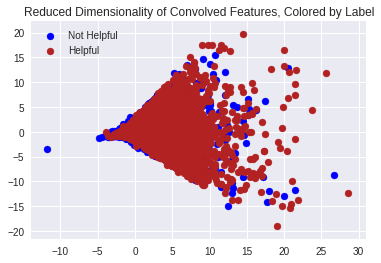

In [45]:
nothelpful = plt.scatter(interm[y_test == 0, 0], interm[y_test == 0, 1], c='b')
helpful = plt.scatter(interm[y_test == 1, 0], interm[y_test == 1, 1], c='firebrick')
plt.legend([nothelpful, helpful], ['Not Helpful', 'Helpful'])
plt.title('Reduced Dimensionality of Convolved Features, Colored by Label')

In [0]:
from keras.datasets import imdb

(x_train, y_train), (x_test, y_test) = imdb.load_data(path="imdb.npz",
                                                      num_words=VOCAB_SIZE,
                                                      skip_top=0,
                                                      maxlen=None,
                                                      seed=113,
                                                      start_char=1,
                                                      oov_char=2,
                                                      index_from=3)
x_train = pad_sequences(x_train, maxlen=MAX_SEQUENCE_LENGTH)
x_test = pad_sequences(x_test, maxlen=MAX_SEQUENCE_LENGTH)

In [53]:
# Experiment with different numbers of filters
EMBEDDING_DIM = 300
VOCAB_SIZE = 10000
NUM_FILTERS = [10, 25, 50]
FILTER_SIZES = [5, 15, 30]
BATCH_SIZE = 64
NUM_EPOCHS = 5


inputs = []
channels = []

for filter_size in FILTER_SIZES:
    input_ = Input(shape=(MAX_SEQUENCE_LENGTH,))
    inputs.append(input_)

    channel = Embedding(VOCAB_SIZE, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH,
                  weights=[embedding_matrix], trainable=True)(input_)
    channel = Conv1D(filters=10, kernel_size=filter_size, padding='valid', 
               activation='relu')(channel)
    channel = MaxPooling1D(2)(channel)
    channel = Flatten()(channel)
    channels.append(channel)

merged = concatenate(channels)
merged = Dropout(0.6)(merged)
outputs = Dense(1, activation='sigmoid')(merged)

imdb_model = Model(inputs=inputs, outputs=outputs)
imdb_model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


print(model.summary())

model.fit([x_train, x_train, x_train], y_train, epochs=NUM_EPOCHS, 
          batch_size=BATCH_SIZE, validation_split=0.2)

y_test_pred = model.predict([x_test, x_test, x_test])
acc = accuracy_score(y_test, np.rint(y_test_pred))

print('Accuracy score: {}'.format(acc))

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 175)          0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, 175)          0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 175)          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 175, 300)     3000000     input_4[0][0]                    
__________________________________________________________________________________________________
embedding_

In [0]:
imdb_intermediate_layer_model = Model(inputs=imdb_model.input,
                                 outputs=imdb_model.layers[-3].output)

In [0]:
imdb_intermediate_output = imdb_intermediate_layer_model.predict([x_test, x_test, x_test])

In [0]:
imdb_pca = PCA(2)
imdb_interm = pca.fit_transform(imdb_intermediate_output)

Text(0.5,1,'Reduced Dimensionality of Convolved Features, Colored by Label')

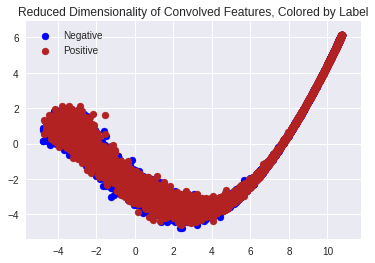

In [58]:
nothelpful = plt.scatter(imdb_interm[y_test == 0, 0], imdb_interm[y_test == 0, 1], c='b')
helpful = plt.scatter(imdb_interm[y_test == 1, 0], imdb_interm[y_test == 1, 1], c='firebrick')
plt.legend([nothelpful, helpful], ['Negative', 'Positive'])
plt.title('Reduced Dimensionality of Convolved Features, Colored by Label')

In [0]:
from sklearn.manifold import TSNE

In [0]:
imdb_tsne = TSNE()
imdb_interm_tsne = imdb_tsne.fit_transform(imdb_intermediate_output)